# Real-Estate Opportunities Prediction
## Identifying Real Estate Opportunities using Machine Learning
In this notebook I aim at developing a machine learning application that identifies opportunities in the real estate market in real time<br/>
**i.e., houses that are currently listed as "for-sale", with a price substantially below the market price.** 
<br/><br/>
This program can be useful for investors interested in the housing market.
<br/>
The goal of this notebook is to provide a detailed real-estate analysis on a selected area. Specifically in this notebook I decided to analyze **Haifa district (Israel)**, and find potential listings which are considered as "real - estate - opportunities".

**The Data:**
The data is taken from Madlan website using the following query:<br/>
https://www.madlan.co.il/homes/getData/?json=%7B%22sortBy%22:%22auto%22,%22zoom%22:18,%22source%22:%22all%22,%22areaId%22:%22%D7%97%D7%99%D7%A4%D7%94%22,%22filter%22:%7B%22dealTypes%22:[%22FOR_SALE%22,%22SOLD%22],%22addBulletinFromPrivate%22:true,%22addBulletinFromAgent%22:false,%22addProjects%22:false,%22conditions%22:[]%7D%7D
<br/><br/>
In order to get the data into a CSV I used "[insomnia](https://insomnia.rest/)" (or any other REST API client) to retrive the JSON from Madlan API.
<br/><br/>
The data consists of 2 types of listings (all listings are in Haifa district):
* **SOLD** Listings: those are listings which were sold in the past
* **FOR-SALE** Listings: those are listings which are currently for sale (we will try to find the opportunity from that list)
<br/>

The implementation of some the machine learning models is based on the following research paper: https://arxiv.org/abs/1809.04933 (I also added a few of my own)<br/>
In addition, I implemented a few more models which do not appear in this paper. Also I did an extensive fearture engineering based on the data that was available to me.


<br/>**Contact Details:**
<br/>Email: yaronv99@gmail.com
<br/>Github: https://github.com/yaronv
<br/>Linkedin: https://www.linkedin.com/in/yaronv/


# Importing the data
Let's start by importing a CSV with all the relevant data.
As you can see below, we have 2 main types of listings:
* SOLD - those are listings which were already sold
* FOR_SALE - thos are listing which are currently for sale

<br/>**Eventually, our machine learning model will use the "SOLD" set for training and evaluation, and the "FOR_SALE" set for finding us the best next real-estate opportunity.**

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import pandas as pd
import os
from matplotlib import pylab as plt
from matplotlib import pyplot
import numpy as np
import requests
import json
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

First, we rename some of the columns to make it more readable (later those will be our features)

In [2]:
houses_df = pd.read_csv('data/haifa-houses-info.csv')
def format_columns(col):
    col = col.replace('location/', 'location-')
    col = col.replace('record/', 'record-')
    col = col.replace('features/', 'listing-')
    col = col.replace('record-listing-', 'listing-')
    return col

houses_df = houses_df.rename(columns=lambda x: format_columns(x))

<br/> Let's translate the house types to english (hebrew labels aren't presented well in plots)

In [3]:
translation = {
     'בניין מגורים' : 'building',
     'דו משפחתי'  : 'bi-family',
     'דופלקס'    : 'duplex',
     'דירה'      : 'appartment',
     'דירת גג'    : 'roof-appartment',
     'דירת גג/פנטהאוז' : 'penthouse',
     'דירת גן'    : 'garden-appartment',
     'חנות'      : 'store',
     "קוטג'"     : 'private-house',
     "קוטג' טורי" : 'private-seq-house'
}

def translate_listing(name):
    if name in translation: 
        return translation[name]
    else:
        return 'missing'
    
houses_df['listing-type'] = houses_df['listing-type'].apply(lambda x: translate_listing(x))
houses_df.head(2)

,type,location-lat,location-lng,location-accurate,location-formattedAddress,record-id,record-type,record-reportDate,record-publishDate,record-updateDate,...,shareTexts/shareUrl,shareTexts/shareTitle,shareTexts/shareText,listing-apartmentNumber,record-agentUrl,record-officeUrl,record-agentName,listing-gardenArea,listing-roof,listing-migrashArea
0,bulletin,32.821382,35.068202,True,"הנוטר 27, חיפה",hFw9BCLVO4p,למכירה,NaN,19/10/2018,19/10/2018,...,https://www.madlan.co.il/bulletin/hFw9BCLVO4p,מודעה מלוח הדירות של אתר מדלן,"דירה, 4 חדרים, 90 מ""ר, קומה 2 מתוך 3, 1,150,00...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bulletin,32.796110,34.990353,True,"שמשון 36, חיפה",kzogitZogX4,למכירה,NaN,04/10/2018,24/10/2018,...,https://www.madlan.co.il/bulletin/kzogitZogX4,מודעה מלוח הדירות של אתר מדלן,"דירה, 4.5 חדרים, 95 מ""ר, קומה 1 מתוך 3, 1,600,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
set(houses_df['listing-type'].values)

{'appartment',
 'bi-family',
 'building',
 'duplex',
 'garden-appartment',
 'penthouse',
 'private-house',
 'private-seq-house',
 'roof-appartment',
 'store'}

# The plan for this notebook

Before starting to actually work on solving the problem, I will outline the basic steps that will guide me through this notebook
* **Data Cleaning & Feature Engineering**
 * Remove unneeded columns
 * Handle missing values
 * Handle date featues
 * Generate more usefull features
 * Do features scaling and normalization
 * Perform a univariate analysis (features histograms)
 * Perform a bivariate analysis (scatter plots of features with the target variable)
 * 1-hot encode categorical features
* **Modeling**
 * Linear Regression
 * Ridge Regression
 * Lasso Regression
 * Random Forest
 * SVM Regressor (SVR)
 * Deep Neural Neteork
* Predicting the best real estate opportunities

# Before we start, let's look at the target variable values distribution

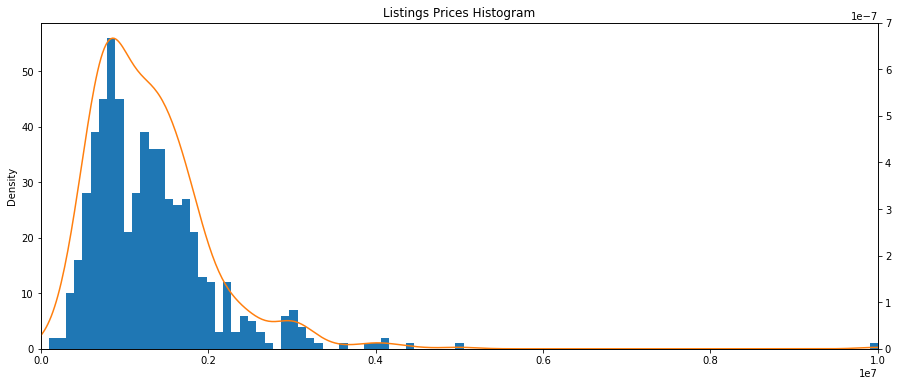

In [5]:
fig, ax = plt.subplots()
col = houses_df['record-price']
col.hist(ax=ax, bins=100, figsize = (15,6), grid=False)
ax2 = col.plot.kde(ax=ax, secondary_y=True, title="Listings Prices Histogram")
ax2.set_ylim(0)
ax2.set_xlim(0, 1e7)
ax2.grid(False)
None

Plotting the target variable values shows that we have a few outliers in the data. Since I'm aiming for "reasonable" listings prices, I will remove them from the dataframe.
<br/>
Remember that our goal here is to **fix the skewed data** and make it more **normally distributed** (later we will also apply a **log transform** to make it better fit a normal distribution)
<br/>
Basically, we usually fix the target variable distribution because outliers have a large effect when the MSE (mean squared error) is calculated.

In [6]:
upper_bound_price = 3000000
print('total outliers removed: %s' % len(houses_df[houses_df['record-price'] > upper_bound_price]))
houses_df = houses_df[houses_df['record-price'] <= upper_bound_price].reset_index(drop=True)

total outliers removed: 16


<br/> This is how the target variable looks like after the outliers removal (we should consider to bin all the values above 0.2e7 for even better looking normal distribution)

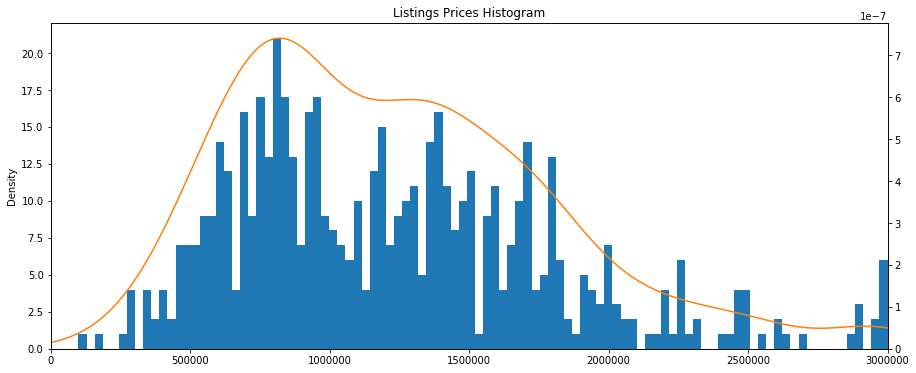

In [7]:
fig, ax = plt.subplots()
col = houses_df['record-price']
col.hist(ax=ax, bins=100, figsize = (15,6), grid=False)
ax2 = col.plot.kde(ax=ax, secondary_y=True, title="Listings Prices Histogram")
ax2.set_ylim(0)
ax2.set_xlim(0, 0.3e7)
ax2.grid(False)
None

# Data Cleaning & Feature Engineering

In this section we're going to do a few cleaning steps in order to improve the quality of our data:
<br/>Let's start by looking at what kind of features do we have...

In [8]:
list(houses_df.columns)

['type',
 'location-lat',
 'location-lng',
 'location-accurate',
 'location-formattedAddress',
 'record-id',
 'record-type',
 'record-reportDate',
 'record-publishDate',
 'record-updateDate',
 'record-price',
 'record-ppm',
 'listing-type',
 'listing-condition',
 'listing-remarks',
 'listing-parkingNum',
 'listing-rooms',
 'listing-floor',
 'listing-floors',
 'listing-buildedArea',
 'listing-grossBuildedArea',
 'listing-buildingYear',
 'listing-hasBalconies',
 'listing-balconiesArea',
 'listing-hasStoreroom',
 'listing-storeroomArea',
 'listing-airCon',
 'listing-elevator',
 'listing-mamad',
 'listing-accessibile',
 'listing-grating',
 'listing-furnitures',
 'listing-suitableForPartners',
 'listing-buildingCommitteeRate',
 'listing-municipalRate',
 'listing-smoking',
 'listing-forMale',
 'listing-forFemale',
 'record-sellerType',
 'record-iconUrl',
 'record-currency',
 'record-exclusive',
 'record-nadlanUrl',
 'record-recommendedForStudents',
 'record-isPromoted',
 'record-translatedNa

* As you can see above, not all columns are relevant for our prediction problem, so it's better to discard them
* Also, many columns contain missing elements, so this should be addressed too

## Drop unneeded columns

In [9]:
# drop irrelevant columns
houses_df = houses_df.drop(['type', 'record-iconUrl', 'record-isPromoted', 'record-translatedType', 'shareTexts/title', 'shareTexts/shareUrl', 'shareTexts/shareTitle','shareTexts/shareText', 'listing-apartmentNumber','record-agentUrl', 'record-officeUrl', 'record-agentName', 'listing-migrashArea', 'record-exclusive', 'record-translatedNadlanType', 'listing-remarks', 'listing-furnitures', 'location-accurate', 'record-currency'], axis=1)

## <br/>Handling Dates
The feature **record-reportDate** is of type date, in order to cature the value of it, we're going to split it into 2 seperate features - **day** / **month**<br/>
* The day variable will be used as a **week counter**. i.e day=6 -> week0, day=10 -> week1 etc...(possible values are [0-4])
* The month variable will be used as a **season indicator**, so we will split the month 1-12 into 4 groups of summer / winter / autumn / spring
* in addition - both variables will have a category of a missing value in case the value is indeed missing

In [10]:
# handle missing dates
houses_df['record-reportDate'].fillna('-1/-1', inplace=True)

def generate_week(num):
    if num == -1:
        return 'missing'
    else:
        return str(int(num/7))

def generate_season(num):
    if num == -1:
        return 'missing'
    elif num == 12 or num == 1 or num == 2:
        return 'winter'
    elif num == 3 or num == 4 or num == 5:
        return 'spring'
    elif num == 6 or num == 7 or num == 8:
        return 'summer'
    else:
        return 'autumn'
    
# keep only day and month
houses_df['record-reportDate-week'] = houses_df['record-reportDate'].apply(lambda x: generate_week(int(x.split("/")[0])))
houses_df['record-reportDate-month'] = houses_df['record-reportDate'].apply(lambda x: generate_season(int(x.split("/")[1])))
houses_df.drop(['record-reportDate'], inplace=True, axis=1)

## <br/>Adding distance to Technion feature
In this section, we want to analyze if listings prices are affected by the **closenes to the Technion**. It is known that many students rent appartments near the Technion, but does it also mean that those appartments worth more?<br/>
We will answer this question by measuring the correlation between the distance and the price value<br/>
How are we going to do it?
* For each listing we will calculate the **haversine distance** to the Technion and use it as a new feature
* We will plot the relation between this feature and the target variable to see the effect
* We will calculate the pearson correlation between the new feature and the target variable

In [11]:
import geopy.distance
   
coords_technion = (32.776905, 35.023195)
houses_df['listing-dis-from-technion'] = houses_df.apply(lambda row: geopy.distance.vincenty((row['location-lat'], row['location-lng']), coords_technion).km, axis=1)

<br/>Let's plot the new feature haversine distance, together with the target variable

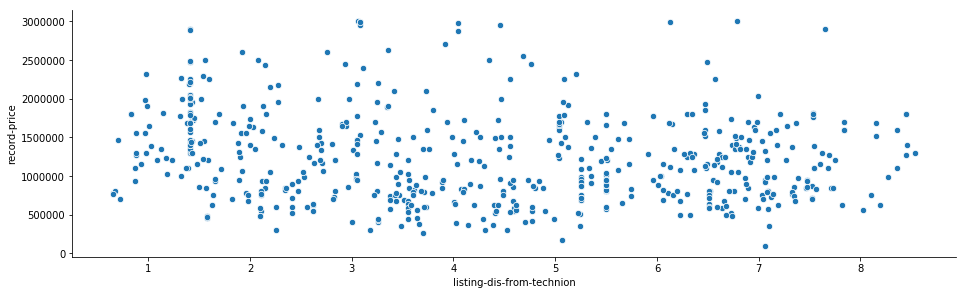

In [12]:
pp = sns.pairplot(data = houses_df,
                  plot_kws = {"s":40},
                  y_vars = tuple(['record-price']),
                  x_vars = ['listing-dis-from-technion'])
pp.fig.set_size_inches(20, 5)

Clearly we see no connection between the haversine distance and the listing price, so we're not going to use this feature.
<br/> Just to be sure, we will also calculate the **pearson correlation** value between the two...

In [13]:
corr_value = houses_df['listing-dis-from-technion'].corr(houses_df["record-price"])
print('Pearson Correlation between the distance_from_technion and the price is %s' % corr_value)

Pearson Correlation between the distance_from_technion and the price is -0.18469236911437542


In [14]:
# drop the new feature
houses_df.drop(['listing-dis-from-technion'], inplace=True, axis=1)

<br/><br/>
**In the next section, we're going to deal with missing values**
<br/> In order to do that, we need to know what types of variables do we have

In [15]:
# Let's see the features types
houses_df.dtypes

location-lat                     float64
location-lng                     float64
location-formattedAddress         object
record-id                         object
record-type                       object
record-publishDate                object
record-updateDate                 object
record-price                     float64
record-ppm                       float64
listing-type                      object
listing-condition                 object
listing-parkingNum               float64
listing-rooms                    float64
listing-floor                      int64
listing-floors                   float64
listing-buildedArea              float64
listing-grossBuildedArea         float64
listing-buildingYear             float64
listing-hasBalconies              object
listing-balconiesArea            float64
listing-hasStoreroom              object
listing-storeroomArea            float64
listing-airCon                    object
listing-elevator                  object
listing-mamad   

<br/><br/>
## Dealing with missing values
After looking at the types of the columns above, we see that many of the "boolean" features are actually assigned as type "object".
This happens due to missing values in those columns, so in order to fix that, we will treat each of those boolean features as categorical ["true", "false", "missing"]
<br/></br>
After a close analysis, we see that these following features will be converted to categorial instead of boolean:
* listing-hasBalconies
* listing-hasStoreroom
* listing-airCon
* listing-elevator                
* listing-mamad                    
* listing-accessibile               
* listing-grating  
* listing-suitableForPartners
* listing-smoking
* listing-forMale   
* listing-forFemale               
* record-recommendedForStudents

In [16]:
bool_cols = ['listing-hasBalconies', 'listing-hasStoreroom', 'listing-airCon', 'listing-elevator', 'listing-mamad', 'listing-accessibile', 'listing-grating', 'listing-suitableForPartners', 'listing-smoking', 'listing-forMale', 'listing-forFemale', 'record-recommendedForStudents']

booleanDictionary = {True: 'true', False: 'false'}

for column in bool_cols:
    houses_df[column] = houses_df[column].map(booleanDictionary)

for column in bool_cols:
    houses_df[column].fillna('missing', inplace=True)

houses_df.head()

,location-lat,location-lng,location-formattedAddress,record-id,record-type,record-publishDate,record-updateDate,record-price,record-ppm,listing-type,...,listing-smoking,listing-forMale,listing-forFemale,record-sellerType,record-nadlanUrl,record-recommendedForStudents,listing-gardenArea,listing-roof,record-reportDate-week,record-reportDate-month
0,32.821382,35.068202,"הנוטר 27, חיפה",hFw9BCLVO4p,למכירה,19/10/2018,19/10/2018,1150000.0,12777.0,appartment,...,false,false,false,individual,https://www.madlan.co.il/homes?mapCenter=32.82...,false,NaN,NaN,missing,missing
1,32.796110,34.990353,"שמשון 36, חיפה",kzogitZogX4,למכירה,04/10/2018,24/10/2018,1600000.0,16842.0,appartment,...,false,false,false,individual,https://www.madlan.co.il/homes?mapCenter=32.79...,false,NaN,NaN,missing,missing
2,32.826835,35.067116,"זייד אלכסנדר 61, חיפה",sold_864536863564911418,נמכר,NaN,NaN,845000.0,9494.0,appartment,...,missing,missing,missing,NaN,https://www.madlan.co.il/homes?filters.dealTyp...,missing,NaN,NaN,1,autumn
3,32.827917,35.060319,"שדרות דגניה, חיפה",dapPgnVcl8R,למכירה,11/06/2018,03/07/2018,590000.0,12553.0,appartment,...,false,false,false,individual,https://www.madlan.co.il/homes?mapCenter=32.82...,false,NaN,NaN,missing,missing
4,32.819710,35.076232,חומה ומגדל 34 חיפה,G1y1r7jyQz,למכירה,20/02/2018,20/06/2018,1350000.0,12272.0,appartment,...,false,false,false,individual,https://www.madlan.co.il/homes?mapCenter=32.81...,false,NaN,NaN,missing,missing


<br/><br/>
Great, now that we converted all the **boolean** features to **categorical** (false,true,missing), we can continue to handle all the other missing values.<br/>
First, let's check which columns contain missing values...
<br/><br/>
But first, let's create a **new dataframe** with only the listings which are **"SOLD"**, because we need to make sure no evaluation data is leaked into the training data (**this will be the dataframe that we will use for training**)

In [17]:
train_df = houses_df[houses_df['record-type'] == 'נמכר'].copy()
train_df.drop(['record-type', 'record-id', 'location-formattedAddress', 'record-nadlanUrl'], axis=1, inplace=True)
print('total train examples are %s' % len(train_df))

total train examples are 288


<br/>Now let's see which columns contain missing values

In [18]:
cols_with_nans = list(train_df.isna().any().where(lambda x: x == True).dropna().keys())
cols_with_nans

['record-publishDate',
 'record-updateDate',
 'listing-condition',
 'listing-parkingNum',
 'listing-buildedArea',
 'listing-grossBuildedArea',
 'listing-balconiesArea',
 'listing-storeroomArea',
 'listing-buildingCommitteeRate',
 'listing-municipalRate',
 'record-sellerType',
 'listing-gardenArea',
 'listing-roof']

<br/><br/>
Next, we plot the amount of missing values for each column, this can tell us more about **how to handle each column**.<br/>
For example, columns with too many missing items, probably it's better for us to discard them from our training data, while columns with small/medium amount of missing values can be fixed with other methods

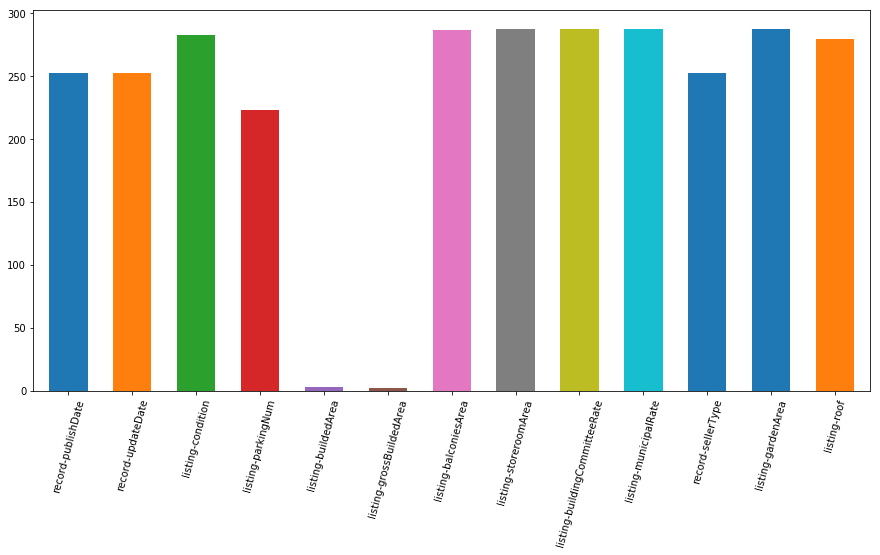

In [19]:
cols_missing_data = train_df[cols_with_nans].apply(lambda x: x.isna().sum(), axis=0)
cols_missing_data.plot(kind='bar', rot=75, figsize=(15,7), width=0.6, grid=False)
None

Let's calculate the features with more than 50% missing values, and drop them from the training set

In [20]:
features_to_drop = cols_missing_data.where(lambda x: x>=len(train_df)/2).dropna().keys()
features_to_drop = [c for c in features_to_drop if c in train_df.columns]
print('those are the features with more than 50% missing values: (those will be removed)')
print(list(features_to_drop))
train_df.drop(features_to_drop, axis=1, inplace=True)

those are the features with more than 50% missing values: (those will be removed)
['record-publishDate', 'record-updateDate', 'listing-condition', 'listing-parkingNum', 'listing-balconiesArea', 'listing-storeroomArea', 'listing-buildingCommitteeRate', 'listing-municipalRate', 'record-sellerType', 'listing-gardenArea', 'listing-roof']


<br/><br/>
**More feature engineering**<br/>
We finished dealing with dropping all the features with more than 50% missing values and the features which are not relevant to our problem. Next we're going to deal with more features, the ones that have less than 50% missing values and need special handling.<br/>
We know that different types of features require different techniques of handling missing values. <br/>
We will investigate each feature and decide the best approach for it.

In [21]:
features_to_fix = cols_missing_data.where(lambda x: x<len(train_df)/2).where(lambda x: x>0).dropna().keys()
features_to_fix = [c for c in features_to_fix if c in train_df.columns]
print('those are the features with less than 50% missing values:')
print(list(features_to_fix))

those are the features with less than 50% missing values:
['listing-buildedArea', 'listing-grossBuildedArea']


<br/>How are we going to handle those features?
* **listing-buildedArea** - we will use the mode value
* **listing-grossBuildedArea** - we will use the mode value
<br/>
<br/> 

We're also going to calculate the **ppm-mean** and the **buildingYear-mode** (we'll need them later in the test set)

In [22]:
# fill missing values
train_builded_area_mode = train_df['listing-buildedArea'].mode()[0]
train_df['listing-buildedArea'].fillna(train_builded_area_mode, inplace=True)
train_gross_builded_area_mode = train_df['listing-grossBuildedArea'].mode()[0]
train_df['listing-grossBuildedArea'].fillna(train_gross_builded_area_mode, inplace=True)

train_ppm_mean = train_df['record-ppm'].mean()
train_buildingYear_mode = train_df['listing-buildingYear'].mode()[0]

In [23]:
# Let's save the training columns so we can use them later with the evaluation set (just to make sure we're using the same columns on train and test)
train_original_columns = list(train_df.columns)

<br/>At this point we should not have missing values in our trainig dataframe, let's validate this is actually the case

In [24]:
cols_with_nans = list(train_df.isna().any().where(lambda x: x == True).dropna().keys())
assert cols_with_nans == []

train_df.head()

,location-lat,location-lng,record-price,record-ppm,listing-type,listing-rooms,listing-floor,listing-floors,listing-buildedArea,listing-grossBuildedArea,...,listing-mamad,listing-accessibile,listing-grating,listing-suitableForPartners,listing-smoking,listing-forMale,listing-forFemale,record-recommendedForStudents,record-reportDate-week,record-reportDate-month
2,32.826835,35.067116,845000.0,9494.0,appartment,3.0,3,4.0,89.0,89.0,...,missing,missing,missing,missing,missing,missing,missing,missing,1,autumn
5,32.821794,35.065087,1265000.0,12281.0,appartment,5.0,2,3.0,103.0,110.0,...,false,false,false,false,false,false,false,false,3,autumn
8,32.804940,34.991352,300000.0,9090.0,appartment,1.0,1,3.0,33.0,43.0,...,missing,missing,missing,missing,missing,missing,missing,missing,1,summer
11,32.808785,34.993631,800000.0,11267.0,appartment,3.5,0,4.0,71.0,71.0,...,false,false,false,false,false,false,false,false,1,summer
14,32.810598,34.994586,550000.0,12500.0,appartment,2.0,2,3.0,44.0,51.0,...,missing,missing,missing,missing,missing,missing,missing,missing,0,summer


## <br/>Univariate Analysis
Let's look at the features histograms to see if we see weird values and outliers.
<br/>Basically, we don't have any assumptions on the independent variables distribution (just on the residuals) - explanation is [here](https://www.quora.com/Should-independent-and-dependent-variables-be-normally-distributed-for-linear-regression)

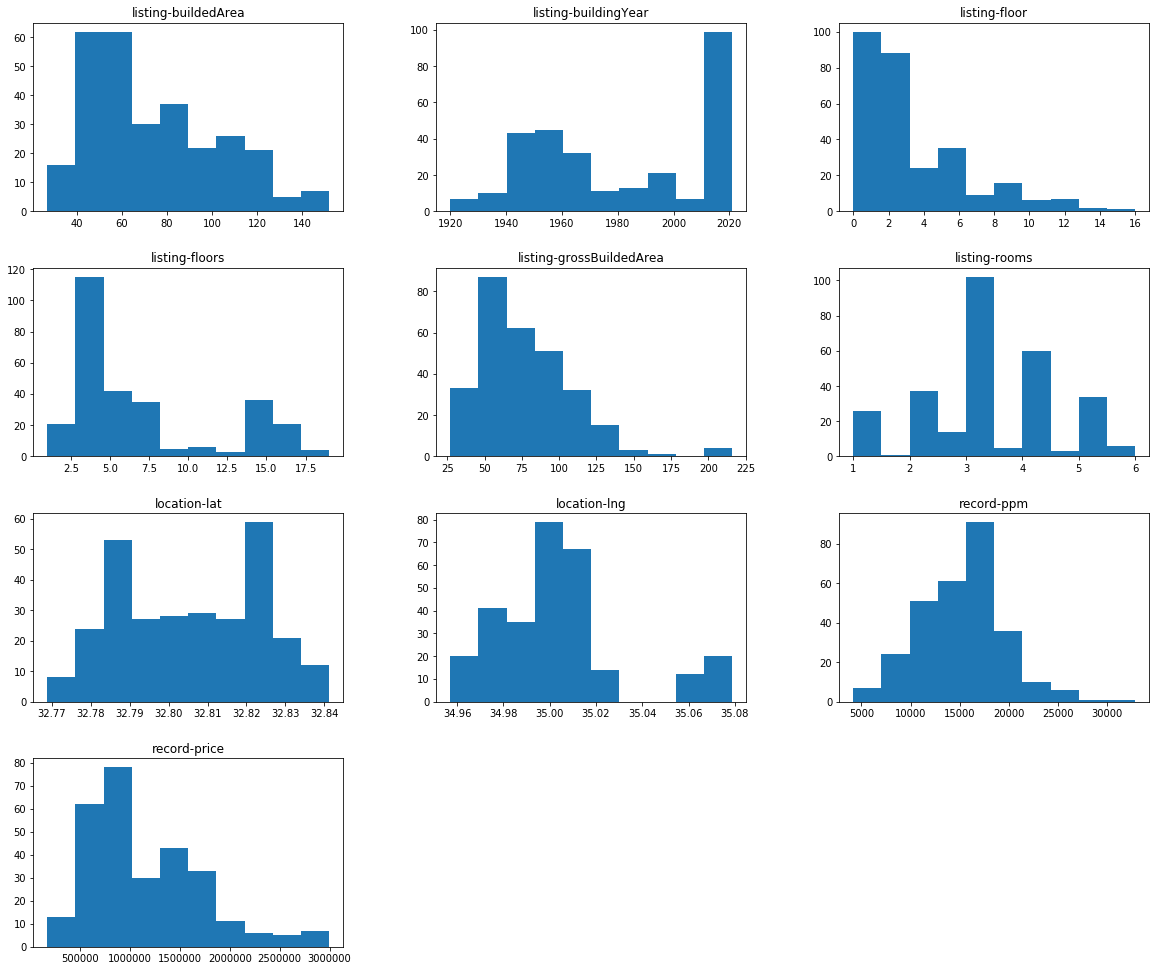

In [25]:
train_df.hist(figsize=(20,17), grid=False)
plt.show()

## <br/>Bivariate Analysis

### Continuous Independent Variables VS Target Variable Analysis
Here, we will use **scatter plots** in order to draw the relationship between our categorical variables and the target variable

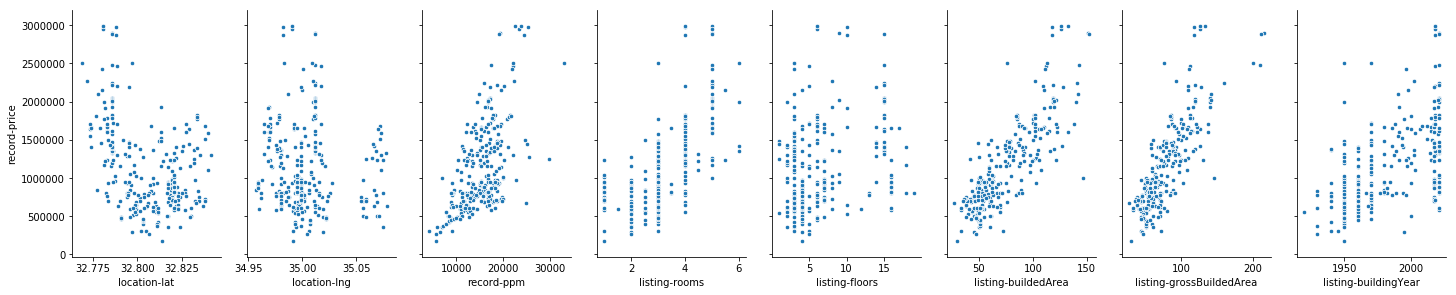

In [26]:
float_cols = list(train_df.select_dtypes(include=['float']))
if 'record-price' in float_cols:
    float_cols.remove('record-price')

pp = sns.pairplot(data = train_df,
#                   kind='reg',
                  plot_kws = {"s":20},
                  y_vars = tuple(['record-price']),
                  x_vars = float_cols)
pp.fig.set_size_inches(20, 5)

We see some pretty strong features with high correlation to our target variable (listing-buildedArea, listing-grossBuildedArea)
<br/>We will make sure our machine learning model picks those features as high indicators for the price prediction
<br/><br/>
Also, we see that the **longitude** and **latitude** features **does not show any relationship** with the target variable, so we will remove them

In [27]:
train_df.drop(['location-lat', 'location-lng'], inplace=True, axis=1)
houses_df.drop(['location-lat', 'location-lng'], inplace=True, axis=1)

<br/>At this point, we finalized our feaures set that we want to use, the next step is to apply some standartization

### <br/>Categorical Independent Variables VS Target Variable Analysis
Here, we will use **box plots** in order to draw the relationship between our categorical variables and the target variable

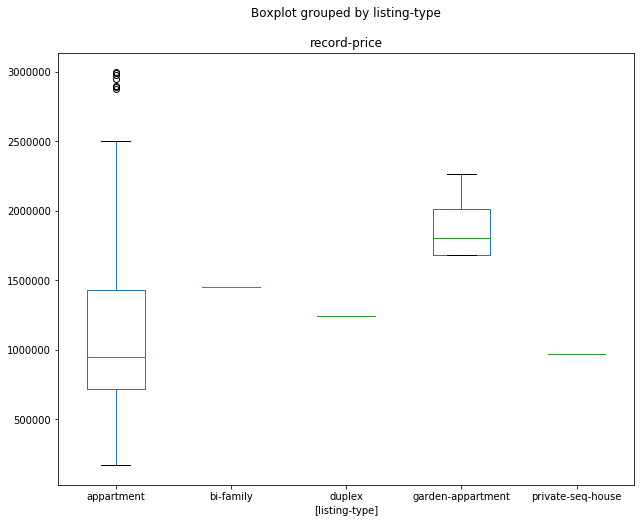

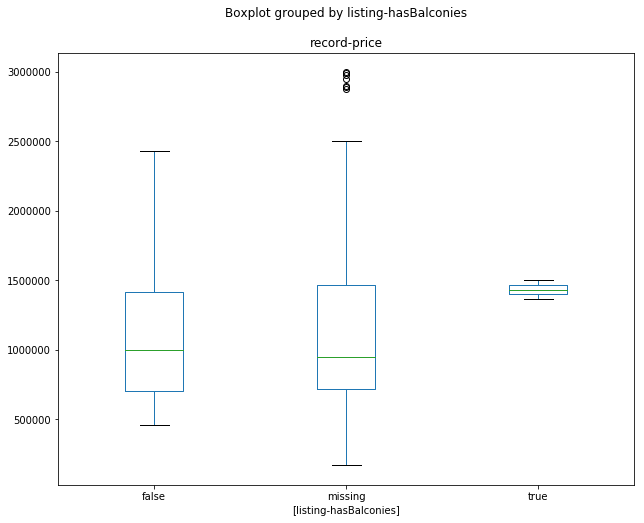

In [28]:
categorical_cols_to_show = list(train_df.select_dtypes(include=['object']).columns)[:2]

for c in list(categorical_cols_to_show):
    train_df[['record-price', c]].boxplot(by=[c], grid=False, figsize=(10, 8))

<br/>At the above we can see 2 things
* Appartments with garden clearly cost more than simple ones
* Appartments with balconies also priced higher than appartments without (we can see the similarity between the box plot of the appartments without balconies and with missing value, this may indicate that we should treat missing balconies as false instead of a new category)
<br/>

We can do this analysis for all categorical features, but I'll skip that

## <br/>Transforming the target variable

<br>We see that the target variable (record-price) is **positive skewed**, let's try to handle it with some transformations
* square root - 
$
\begin{align}
\sqrt[2]{x}
\end{align}
$
* cube root - 
$
\begin{align}
\sqrt[3]{x}
\end{align}
$
* log - 
$
\begin{align}
\log{x}
\end{align}
$

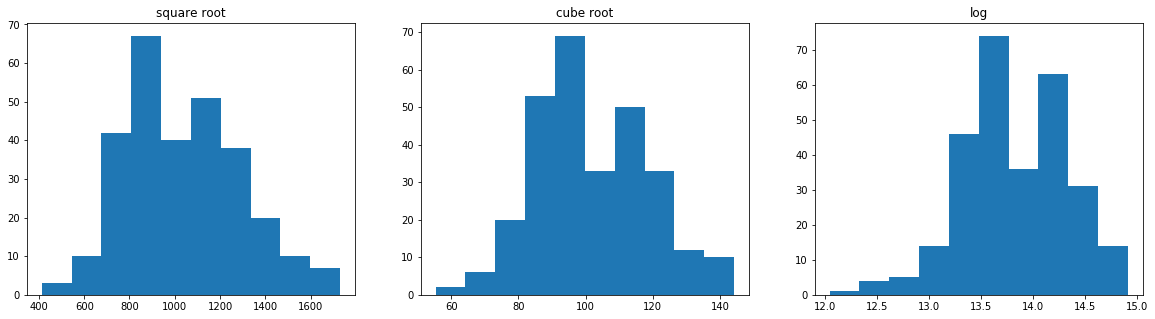

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, clear=True)

train_df['record-price'].apply(np.sqrt).hist(ax=ax1, figsize=(20,5), grid=False)
ax1.set_title('square root')

train_df['record-price'].apply(np.cbrt).hist(ax=ax2, grid=False)
ax2.set_title('cube root')

train_df['record-price'].apply(np.log).hist(ax=ax3, grid=False)
ax3.set_title('log')

plt.show()

<br/>From the above we see that the **square root transformation** gives the best looking normal distribution, so let's apply it to our target variable

In [30]:
train_df['record-price'] = train_df['record-price'].apply(np.sqrt)

In [31]:
# print the types of features that we have
train_df.dtypes

record-price                     float64
record-ppm                       float64
listing-type                      object
listing-rooms                    float64
listing-floor                      int64
listing-floors                   float64
listing-buildedArea              float64
listing-grossBuildedArea         float64
listing-buildingYear             float64
listing-hasBalconies              object
listing-hasStoreroom              object
listing-airCon                    object
listing-elevator                  object
listing-mamad                     object
listing-accessibile               object
listing-grating                   object
listing-suitableForPartners       object
listing-smoking                   object
listing-forMale                   object
listing-forFemale                 object
record-recommendedForStudents     object
record-reportDate-week            object
record-reportDate-month           object
dtype: object

## <br/>Encoding categorical variables
We will encode all the following categorical variables (all the type 'object')
* listing-type
* listing-hasBalconies
* listing-hasStoreroom
* listing-airCon
* listing-elevator
* listing-mamad
* listing-accessibile
* listing-grating
* listing-suitableForPartners
* listing-smoking
* listing-forMale
* listing-forFemale
* record-recommendedForStudents
* record-reportDate-week
* record-reportDate-month

In [32]:
original_float_cols = train_df.select_dtypes(include=['float64']).columns

# 1-hot encode the features
cols_to_encode = train_df.select_dtypes(include=['object']).columns

label_encoders = {}
one_hot_encoders = {}

encoded_cols_saved = list(cols_to_encode)

for c in cols_to_encode:
    if c in houses_df.columns:
        label_encoders[c] = LabelEncoder().fit(houses_df[c])
        train_df[c] = label_encoders[c].transform(train_df[c])
        houses_df[c] = label_encoders[c].transform(houses_df[c])
        one_hot_encoders[c] = OneHotEncoder(sparse=False, categories='auto').fit(houses_df[c].values.reshape(-1, 1))
    else:
        label_encoders[c] = LabelEncoder().fit(train_df[c])
        train_df[c] = label_encoders[c].transform(train_df[c])
        one_hot_encoders[c] = OneHotEncoder(sparse=False, categories='auto').fit(train_df[c].values.reshape(-1, 1))
        
all_encoded_df = pd.DataFrame()

for c in cols_to_encode:
    c_encoded = one_hot_encoders[c].transform(train_df[c].values.reshape(-1, 1))
    df_one_hot = pd.DataFrame(c_encoded, columns = [c + "_" + str(label_encoders[c].inverse_transform([i])[0]) for i in range(c_encoded.shape[1])])
    all_encoded_df = pd.concat([all_encoded_df, df_one_hot], axis=1)
    train_df.drop([c], inplace=True, axis=1)
    
train_df = pd.concat([train_df.reset_index(drop=True), all_encoded_df.reset_index(drop=True)], axis=1)

train_df.head()

,record-price,record-ppm,listing-rooms,listing-floor,listing-floors,listing-buildedArea,listing-grossBuildedArea,listing-buildingYear,listing-type_appartment,listing-type_bi-family,...,record-reportDate-week_1,record-reportDate-week_2,record-reportDate-week_3,record-reportDate-week_4,record-reportDate-week_missing,record-reportDate-month_autumn,record-reportDate-month_missing,record-reportDate-month_spring,record-reportDate-month_summer,record-reportDate-month_winter
0,919.238816,9494.0,3.0,3,4.0,89.0,89.0,1960.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1124.722188,12281.0,5.0,2,3.0,103.0,110.0,1998.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,547.722558,9090.0,1.0,1,3.0,33.0,43.0,1940.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,894.427191,11267.0,3.5,0,4.0,71.0,71.0,1980.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,741.619849,12500.0,2.0,2,3.0,44.0,51.0,1970.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## <br/>Features Standartization
The result of standardization (or Z-score normalization) is that the features will be rescaled so that they’ll have the properties of a standard normal distribution with
<br/><br/>
   **μ = 0 and σ = 1**
<br/><br/>
Where μ is the mean (average) and σ is the standard deviation from the mean<br/><br/>
Standard scores (also called z scores) of the samples are calculated as follows:
<br/><br/>
        **z = (x−μ) / σ**
<br/><br/>
Standardizing the features so that they are centered around 0 with a standard deviation of 1 is not only important if we are comparing measurements that have different units, but it is also a general requirement for many machine learning algorithms.
<br/><br/>**We will standartize only the float variables (continues variables)**

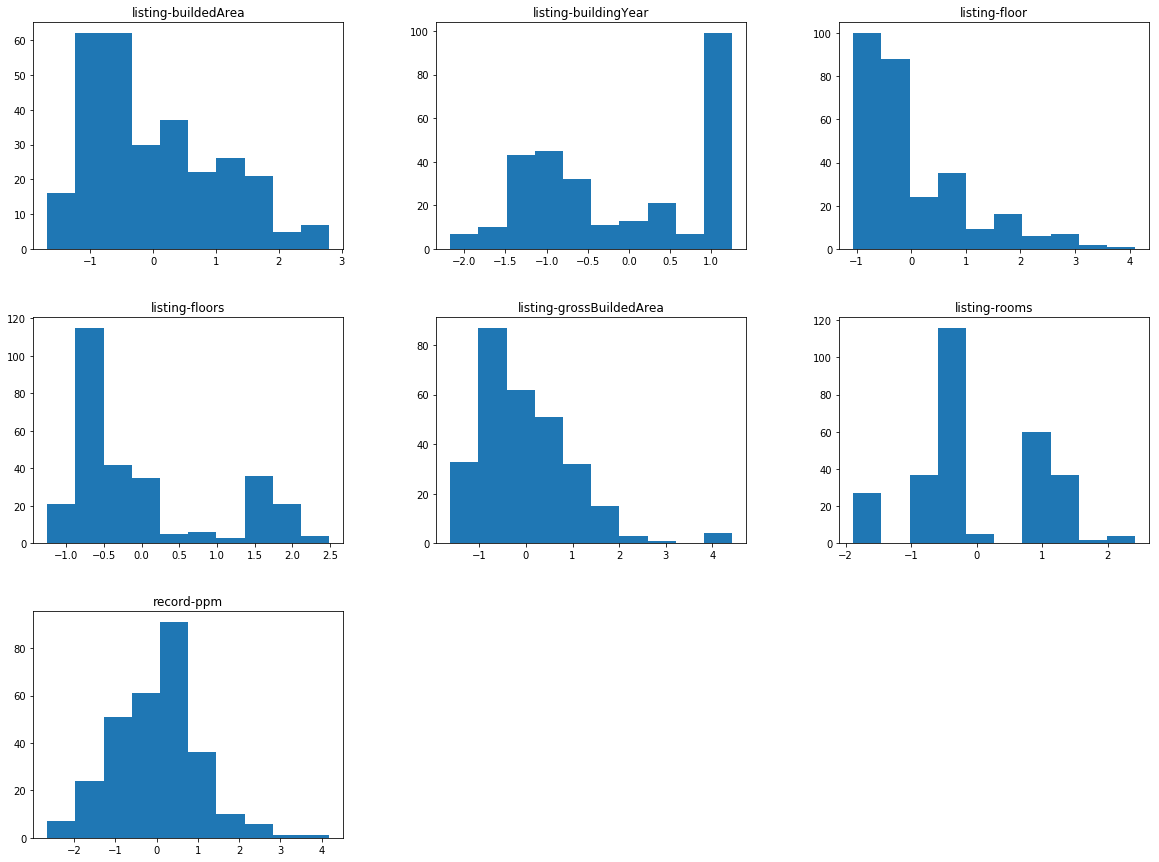

In [33]:
from sklearn import preprocessing

scalerX = preprocessing.StandardScaler()
scalerY = preprocessing.StandardScaler()

cols_to_scale = ['listing-grossBuildedArea', 'listing-buildedArea', 'listing-buildingYear', 'listing-floor', 'listing-floors', 'listing-rooms', 'record-ppm']
scalerX.fit(train_df[cols_to_scale].values)
scaled_df = scalerX.transform(train_df[cols_to_scale].values)
train_df[cols_to_scale] = scaled_df

# create the y dataframe
scalerY.fit(train_df['record-price'].values.reshape(-1, 1))
train_df['record-price'] = scalerY.transform(train_df['record-price'].values.reshape(-1, 1))

train_df[cols_to_scale].hist(figsize=(20,15), grid=False)
plt.show()

<br/>Let's also look at the standartized target variable histogram

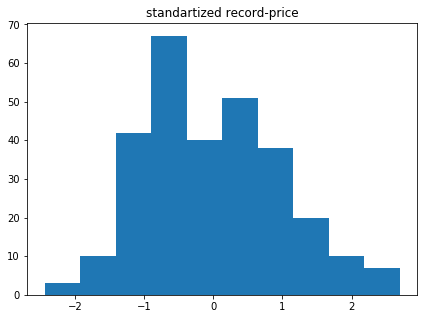

In [34]:
fig = train_df['record-price'].hist(figsize=(7,5), grid=False)
fig.set_title('standartized record-price')
plt.show()

## Features Correlation
Here we're going to calculate the pearson correlation value for the most correlated features to the target variable:
* The most positive correlated
* The most negative correlate

In [35]:
print('Most positive correlated features with the listing price are:')
print(train_df.drop("record-price", axis=1).apply(lambda x: x.corr(train_df["record-price"])).sort_values(ascending=False).head())
print('---------------------------------------')
print('Most negative correlated features with the listing price are:')
print(train_df.drop("record-price", axis=1).apply(lambda x: x.corr(train_df["record-price"])).sort_values(ascending=True).head())

# uncomment to see the full pearson correlation matrix
# corr = train_df.corr()
# corr.style.background_gradient()
# corr.style.background_gradient().set_precision(2)

Most positive correlated features with the listing price are:
listing-buildedArea         0.820605
listing-grossBuildedArea    0.806827
listing-rooms               0.662611
record-ppm                  0.625880
listing-buildingYear        0.560275
dtype: float64
---------------------------------------
Most negative correlated features with the listing price are:
listing-type_appartment          -0.133471
record-reportDate-week_0         -0.080510
record-reportDate-month_autumn   -0.058779
record-reportDate-week_2         -0.048133
record-reportDate-week_1         -0.038878
dtype: float64


# <br/> Modeling
We will start with a few basic machine learning approaches to deal with our problem<br/>
For each model, we will calculate the **MSE** (mean squared error) and **R^2**, also for some of the models we will print the **Coefficient of the features** to see which ones the model relies on the most and the **residual vs fitted** plot to make sure we don't have [heteroskedasticity](http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html) or non-linearity in the data
<br/><br/>
These are the machine learning models that we're going to try:
* Linear Regression
* Ridge Regression
* Lasso Regression
* Random Forest
* SVM Regressor (SVR)
* Deep Neural Neteork


<br/>**A few words about linear-regression**
<br/>One of the assumptions of linear regression models is that the residuals are normally distributed with constant variance - this is something we need to have in order to allow statistical inference regarding the model's coefficients.
<br/>For example:
* In case we want to interpret the coefficients (I.E - "an increase of 10 units in variable X1 will result an increase of 100 units in the target variable)
* In case we want to calculate the p-value of the coefficients - this is done in order to show that this variable is indeed significant (and not actually zero)

<br/>Model interpretation is explained better [here](https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/#7.-Interpreting-Model-Coefficients)
<br/>Justification for the linear regression assumptions are explained [here](http://people.duke.edu/~rnau/regintro.htm)

## Linear Regression

MSE is: 0.02382848590236432
R^2 score is: 0.9764184757472545


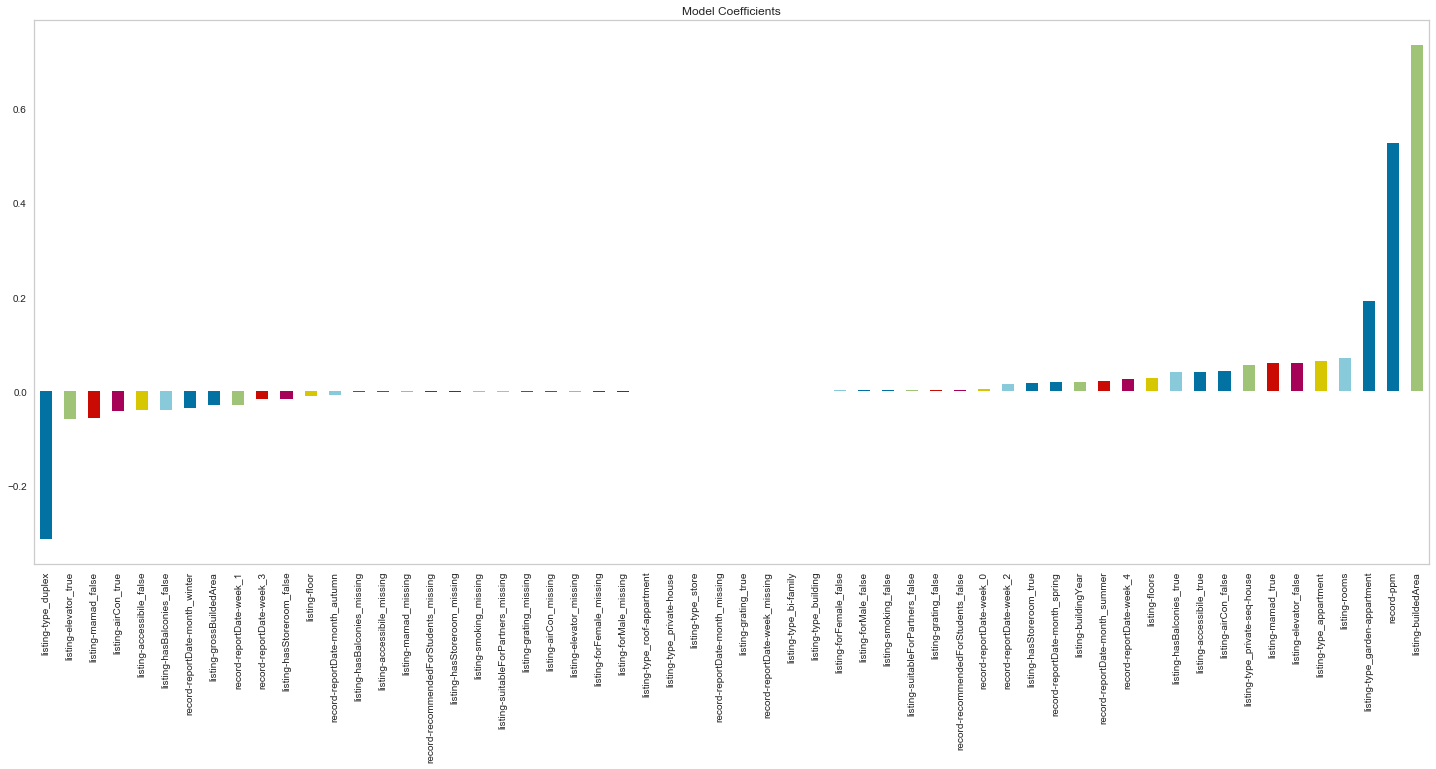

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, PredictionError

lreg = LinearRegression()

train_df_x = train_df.loc[:, train_df.columns != 'record-price']
train_df_y = train_df.loc[:,'record-price']

# splitting into training and cv for cross validation
x_train, x_test, y_train, y_test = train_test_split(train_df_x, train_df_y, random_state=33)

# training the model
lreg.fit(x_train, y_train)

# predicting on test
pred = lreg.predict(x_test)

# calculating mse
mse = np.mean((pred - y_test)**2)

print('MSE is: %s' % mse)
print('R^2 score is: %s' % lreg.score(x_test, y_test))

coeff = pd.DataFrame(x_train.columns)
coeff['Coefficient Estimate'] = pd.Series(lreg.coef_)

predictors = x_train.columns
coef = pd.Series(lreg.coef_,predictors).sort_values()
coef.plot(kind='bar', title='Model Coefficients', figsize=(25,10), grid=False)
None

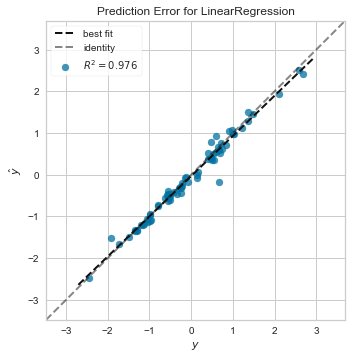

In [37]:
model = PredictionError(lreg)
model.score(x_test, y_test)
model.poof()

### <br/> Plotting residuals vs fitted to see if we have heteroskedestacity or non-linearity

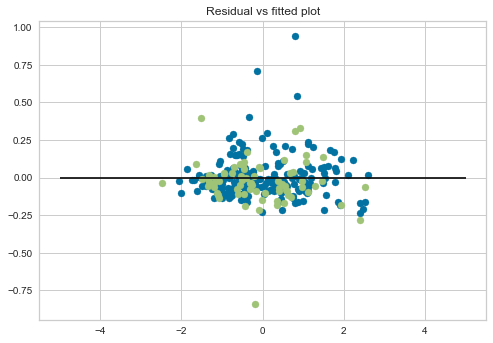

In [38]:
plt.scatter(lreg.predict(x_train), (lreg.predict(x_train) - y_train), c='b')
plt.scatter(pred, (pred - y_test), c='g')
plt.hlines(y=0, xmin= -5, xmax=5)
plt.title('Residual vs fitted plot')
None

The **Residuals vs Fitted** plot can reveal 2 things:
* **heteroskedestacity** - in this case, we will see a funnel like curve (not our case)
* **non-linearity** - in this case we will see a U shape (not our case)

In our case we can't see a clear pattern - which is good. Meaning we have neither heteroskedestacity nor non-linearity in our data

### <br/> Plotting the QQ-Plot to make sure the residuals are normally distributed

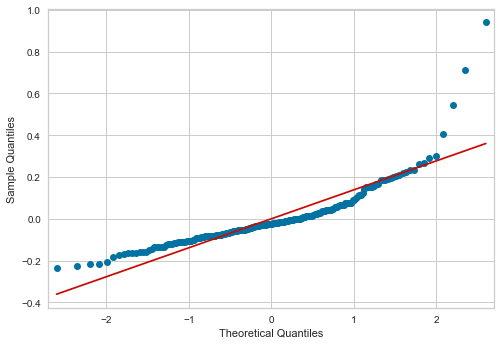

In [39]:
from statsmodels.graphics.gofplots import qqplot
qqplot((lreg.predict(x_train) - y_train), line='s')
pyplot.show()

Residuals looks fairly normally distributed

## Ridge Regression

MSE is: 0.023738105038741093
R^2 score is: 0.9765079198913873


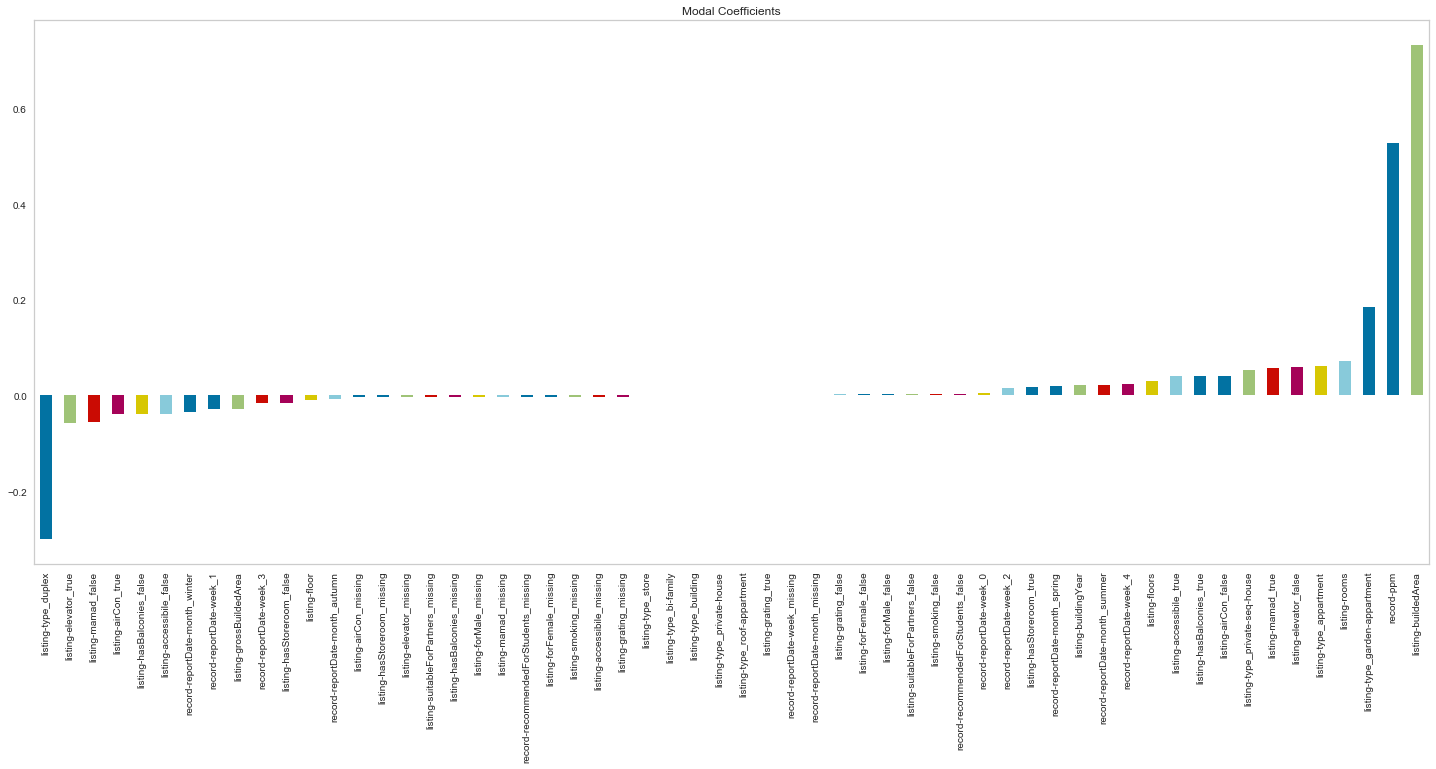

In [40]:
from sklearn.linear_model import Ridge

## training the model
ridgeReg = Ridge(alpha=0.05, normalize=False)

ridgeReg.fit(x_train,y_train)

pred = ridgeReg.predict(x_test)

# calculating mse
mse = np.mean((pred - y_test)**2)
print('MSE is: %s' % mse)
print('R^2 score is: %s' % ridgeReg.score(x_test, y_test))

# checking the magnitude of coefficients
predictors = x_train.columns
coef = pd.Series(ridgeReg.coef_,predictors).sort_values()
coef.plot(kind='bar', title='Modal Coefficients', figsize=(25,10), grid=False)
None

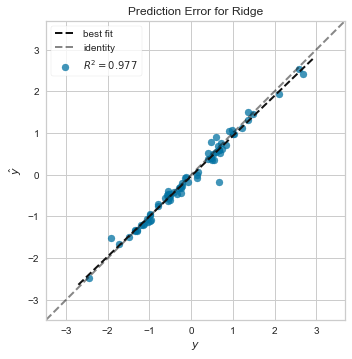

In [41]:
model = PredictionError(ridgeReg)
model.score(x_test, y_test)
model.poof()

## Lasso Regression

MSE is: 0.02271361459799863
R^2 score is: 0.9775217923746858


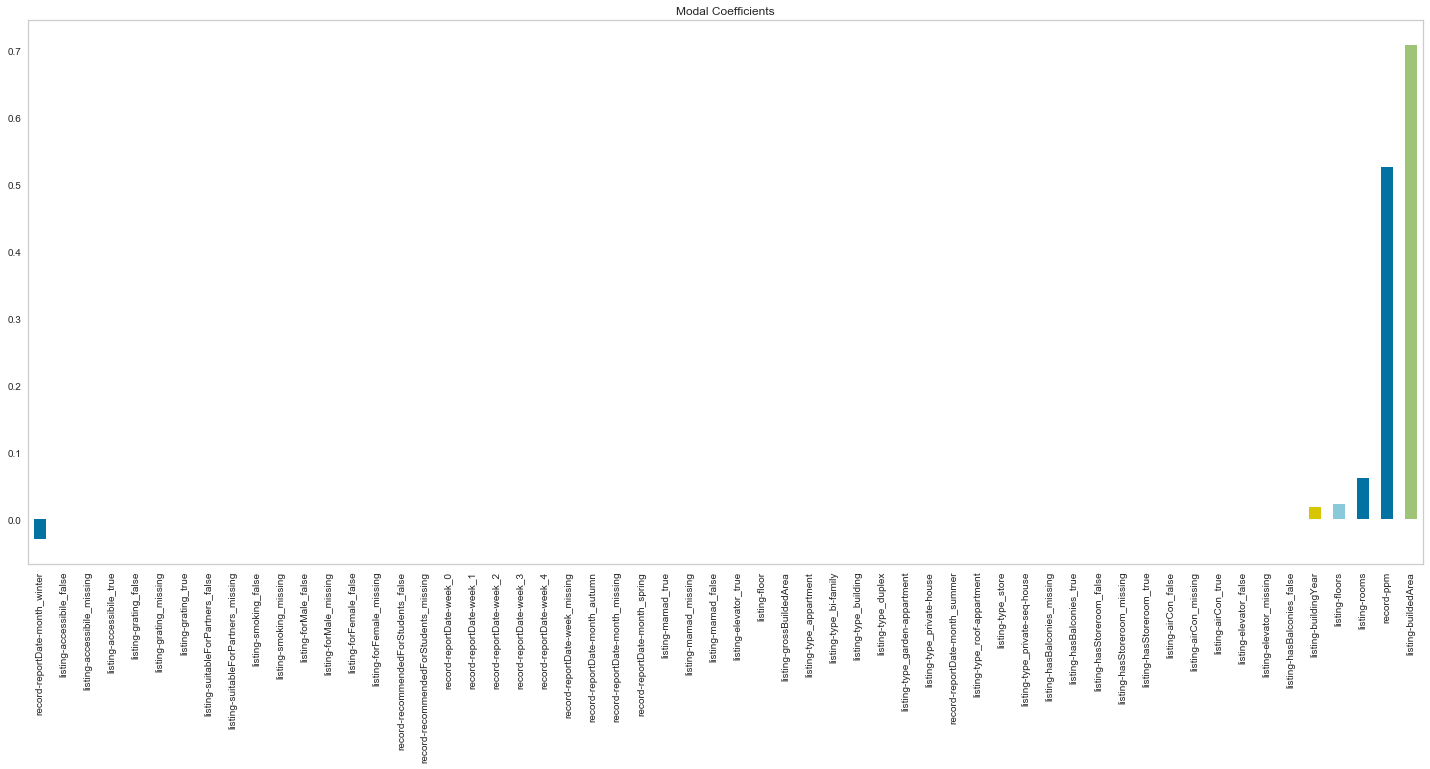

In [42]:
from sklearn.linear_model import Lasso

lassoReg = Lasso(alpha=0.005, normalize=False)

lassoReg.fit(x_train,y_train)

pred = lassoReg.predict(x_test)

# calculating mse

mse = np.mean((pred - y_test)**2)
print('MSE is: %s' % mse)
print('R^2 score is: %s' % lassoReg.score(x_test, y_test))

# checking the magnitude of coefficients
predictors = x_train.columns
coef = pd.Series(lassoReg.coef_,predictors).sort_values()
coef.plot(kind='bar', title='Modal Coefficients', figsize=(25,10), grid=False)
None

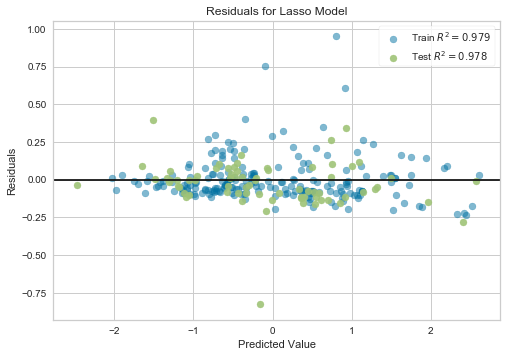

In [43]:
visualizer = ResidualsPlot(lassoReg, hist=False)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)  
visualizer.poof()      

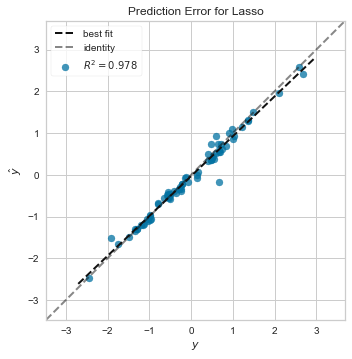

In [44]:
visualizer = PredictionError(lassoReg) 
visualizer.score(x_test, y_test)  
g = visualizer.poof()             

## Random Forest Regressor

In [45]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

rf.fit(x_train,y_train)

predictions = rf.predict(x_test)

errors = abs(predictions - y_test)

print('MSE is:', round(np.mean(errors), 2))
print('R^2 score is: %s' % rf.score(x_test, y_test))

MSE is: 0.14
R^2 score is: 0.95837840414931


In [46]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_train.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: listing-buildedArea  Importance: 0.55
Variable: record-ppm           Importance: 0.25
Variable: listing-grossBuildedArea Importance: 0.19
Variable: listing-rooms        Importance: 0.01
Variable: listing-floor        Importance: 0.0
Variable: listing-floors       Importance: 0.0
Variable: listing-buildingYear Importance: 0.0
Variable: listing-type_appartment Importance: 0.0
Variable: listing-type_bi-family Importance: 0.0
Variable: listing-type_building Importance: 0.0
Variable: listing-type_duplex  Importance: 0.0
Variable: listing-type_garden-appartment Importance: 0.0
Variable: listing-type_private-house Importance: 0.0
Variable: listing-type_private-seq-house Importance: 0.0
Variable: listing-type_roof-appartment Importance: 0.0
Variable: listing-type_store   Importance: 0.0
Variable: listing-hasBalconies_false Importance: 0.0
Variable: listing-hasBalconies_missing Importance: 0.0
Variable: listing-hasBalconies_true Importance: 0.0
Variable: listing-hasStoreroom_false Imp

### Print the variable importance

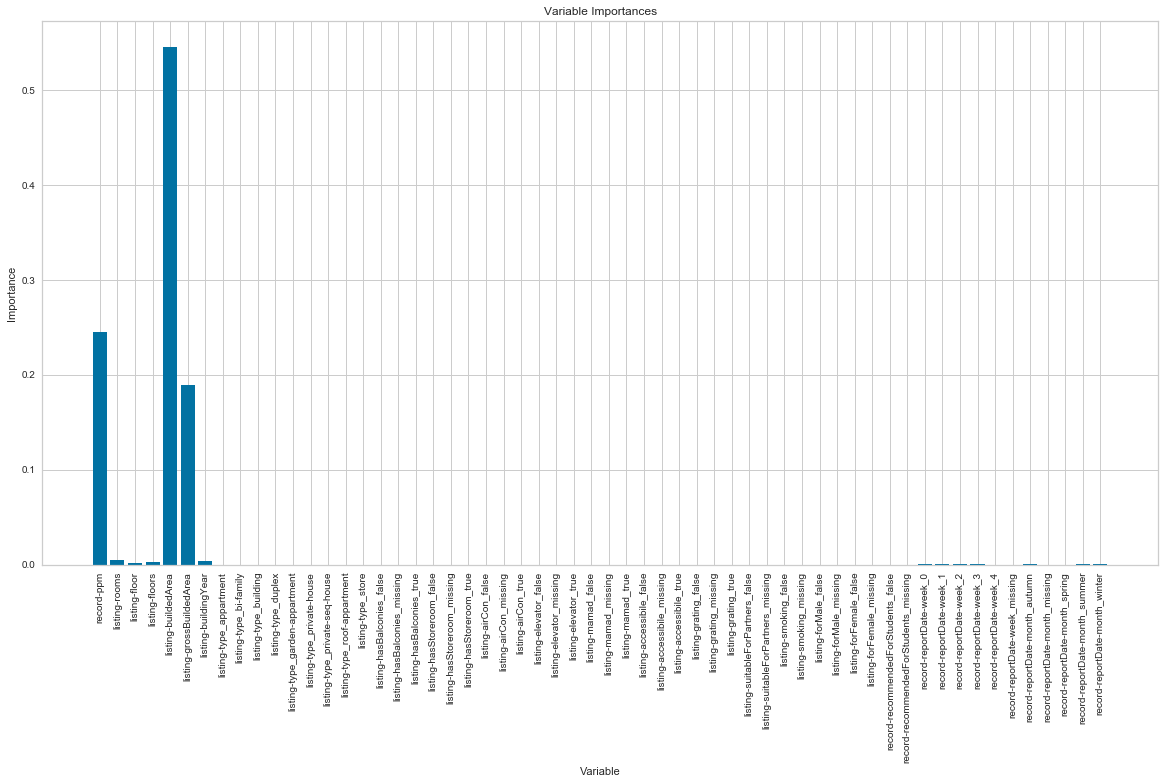

In [47]:
plt.figure(figsize=(20,10))
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')

plt.xticks(x_values, x_train.columns, rotation='vertical')
# Axis labels and title

plt.ylabel('Importance') 
plt.xlabel('Variable')
plt.title('Variable Importances');

## SV Regressor (SVM)

In [48]:
from sklearn.svm import SVR

clf = SVR(C=1e3, kernel='linear')
clf.fit(x_train, y_train) 

predictions = clf.predict(x_test)

errors = abs(predictions - y_test)

print('MSE is:', round(np.mean(errors), 2))
print('R^2 score is: %s' % clf.score(x_test, y_test))

MSE is: 0.1
R^2 score is: 0.977701046751157


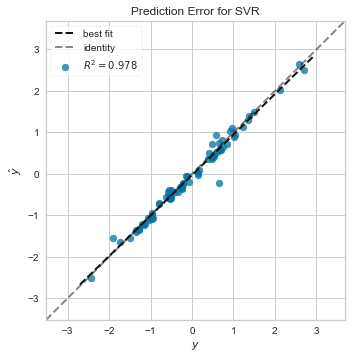

In [49]:
visualizer = PredictionError(clf) 
visualizer.score(x_test, y_test)  
g = visualizer.poof() 

## Deep Neural Network

In [50]:
from keras.models import Sequential
from keras.layers import Dense

X = x_train
Y = y_train

dl_model = Sequential()

dl_model.add(Dense(64, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
dl_model.add(Dense(32, kernel_initializer='normal', activation='relu'))
dl_model.add(Dense(1, activation='linear'))

dl_model.compile(loss='mse', optimizer='adam',  metrics=['mse'])

history = dl_model.fit(X, Y, epochs=150, validation_data=(x_test,y_test))

# make a prediction
predictions = dl_model.predict(x_test)

Using TensorFlow backend.


Train on 216 samples, validate on 72 samples
Epoch 1/150
216/216 [==============================] - 0s 1ms/step - loss: 0.8889 - mean_squared_error: 0.8889 - val_loss: 0.7746 - val_mean_squared_error: 0.7746
Epoch 2/150
216/216 [==============================] - 0s 59us/step - loss: 0.6457 - mean_squared_error: 0.6457 - val_loss: 0.5417 - val_mean_squared_error: 0.5417
Epoch 3/150
216/216 [==============================] - 0s 57us/step - loss: 0.3963 - mean_squared_error: 0.3963 - val_loss: 0.3160 - val_mean_squared_error: 0.3160
Epoch 4/150
216/216 [==============================] - 0s 52us/step - loss: 0.2144 - mean_squared_error: 0.2144 - val_loss: 0.1917 - val_mean_squared_error: 0.1917
Epoch 5/150
216/216 [==============================] - 0s 77us/step - loss: 0.1442 - mean_squared_error: 0.1442 - val_loss: 0.1526 - val_mean_squared_error: 0.1526
Epoch 6/150
216/216 [==============================] - 0s 72us/step - loss: 0.1038 - mean_squared_error: 0.1038 - val_loss: 0.1108 - val

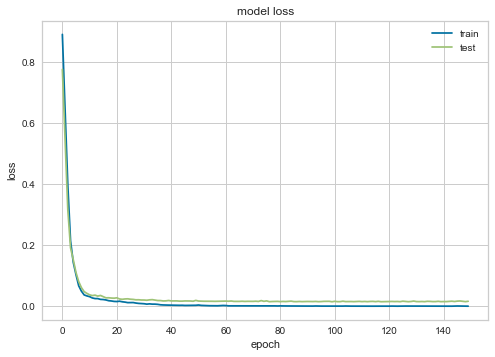

In [51]:
# plot the MSE value as we do more iteration
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [52]:
mse = dl_model.evaluate(x_test, y_test, verbose=0)[0]
print('MSE is: %s' % mse)

MSE is: 0.01666777508540286


# <br/>Now the fun part...
## Let's find the best opportunities currently available in the market
<br/>
We're going to take all the listing which are currently FOR-SALE and apply the following steps:

* apply the labeling / encoding that we did to the features in the training set
* apply features standartization / transforms exactly as we did in training
* use the **best trained model** to predict the real value of the listings
* find the best opportunities, meaning listings with high predicted value but low selling price

In [53]:
opportunities_df = houses_df[houses_df['record-type'] == 'למכירה'].copy().reset_index(drop=True)
print('total opportunities are %s' % len(opportunities_df))

total opportunities are 286


We need to fill missing values the same way we did in training
* listing-buildedArea - we will use the mode value that we calculated for the training examples
* listing-grossBuildedArea - we will use the mean value that we calculated for the training examples
* record-ppm - we will use the mode value that we calculated for the training examples
* listing-floors - we will use 0
* listing-buildingYear - we will use the mode value that we calculated for the training examples

In [54]:
opportunities_df['listing-buildedArea'].fillna(train_builded_area_mode, inplace=True)
opportunities_df['listing-grossBuildedArea'].fillna(train_gross_builded_area_mode, inplace=True)
opportunities_df['record-ppm'].fillna(train_ppm_mean, inplace=True)
opportunities_df['listing-floors'].fillna(0, inplace=True)
opportunities_df['listing-buildingYear'].fillna(train_buildingYear_mode, inplace=True)
opportunities_df.head()

,location-formattedAddress,record-id,record-type,record-publishDate,record-updateDate,record-price,record-ppm,listing-type,listing-condition,listing-parkingNum,...,listing-smoking,listing-forMale,listing-forFemale,record-sellerType,record-nadlanUrl,record-recommendedForStudents,listing-gardenArea,listing-roof,record-reportDate-week,record-reportDate-month
0,"הנוטר 27, חיפה",hFw9BCLVO4p,למכירה,19/10/2018,19/10/2018,1150000.0,12777.0,0,משופץ,1.0,...,0,0,0,individual,https://www.madlan.co.il/homes?mapCenter=32.82...,0,NaN,NaN,5,1
1,"שמשון 36, חיפה",kzogitZogX4,למכירה,04/10/2018,24/10/2018,1600000.0,16842.0,0,משופץ,1.0,...,0,0,0,individual,https://www.madlan.co.il/homes?mapCenter=32.79...,0,NaN,NaN,5,1
2,"שדרות דגניה, חיפה",dapPgnVcl8R,למכירה,11/06/2018,03/07/2018,590000.0,12553.0,0,משופץ,0.0,...,0,0,0,individual,https://www.madlan.co.il/homes?mapCenter=32.82...,0,NaN,NaN,5,1
3,חומה ומגדל 34 חיפה,G1y1r7jyQz,למכירה,20/02/2018,20/06/2018,1350000.0,12272.0,0,משופץ,1.0,...,0,0,0,individual,https://www.madlan.co.il/homes?mapCenter=32.81...,0,NaN,NaN,5,1
4,"רש""י 17, חיפה",z8dOKDaFRU,למכירה,11/10/2018,11/10/2018,830000.0,13833.0,0,כחדש,0.0,...,0,0,0,individual,https://www.madlan.co.il/homes?mapCenter=32.80...,0,NaN,NaN,5,1


<br/>If we have rows with missing 'record-price' value, we have to drop those rows since this value is mandatory for the best opportunity calculation

In [55]:
opportunities_df = opportunities_df.dropna(subset=['record-price']).reset_index(drop=True)
print('total opportunities are %s' % len(opportunities_df))

total opportunities are 286


<br/>Save meta information so we can idenify the listings later

In [56]:
# save some meta info for later
meta_info = opportunities_df[['record-id', 'location-formattedAddress', 'record-nadlanUrl']].copy()
opportunities_df.drop(['record-id', 'location-formattedAddress', 'record-nadlanUrl'], inplace=True, axis=1)

<br/>keep only the columns that we used in training

In [57]:
opp_cols = opportunities_df.columns
for col in opp_cols:
    if not col in train_original_columns:
        opportunities_df.drop([col], inplace=True, axis=1)
        
opportunities_df.head()

,record-price,record-ppm,listing-type,listing-rooms,listing-floor,listing-floors,listing-buildedArea,listing-grossBuildedArea,listing-buildingYear,listing-hasBalconies,...,listing-mamad,listing-accessibile,listing-grating,listing-suitableForPartners,listing-smoking,listing-forMale,listing-forFemale,record-recommendedForStudents,record-reportDate-week,record-reportDate-month
0,1150000.0,12777.0,0,4.0,2,3.0,90.0,105.0,1988.0,2,...,0,0,2,0,0,0,0,0,5,1
1,1600000.0,16842.0,0,4.5,1,3.0,95.0,70.0,1979.0,0,...,0,0,2,0,0,0,0,0,5,1
2,590000.0,12553.0,0,2.5,1,4.0,47.0,54.0,1960.0,0,...,0,0,2,0,0,0,0,0,5,1
3,1350000.0,12272.0,0,5.0,1,4.0,110.0,70.0,1960.0,2,...,2,0,0,0,0,0,0,0,5,1
4,830000.0,13833.0,0,3.0,1,3.0,60.0,65.0,1960.0,2,...,0,0,2,0,0,0,0,0,5,1


<br/>Let's see if we have missing values in any of the columns (and make sure we don't)

In [58]:
missing_values_columns = list(opportunities_df.isna().any().where(lambda x: x == True).dropna().keys())
assert missing_values_columns == []

## <br/> Filtering according to personal preferences
We're going to filter the opportunities list to match our needs, the listing I would like to invest in should be:
* more than 40 square meters
* not more than 700K NIS

In [59]:
opportunities_df = opportunities_df[opportunities_df['listing-buildedArea'] >= 40]#.reset_index(drop=True)
opportunities_df = opportunities_df[opportunities_df['record-price'] <= 700000]#.reset_index(drop=True)
selected_indexes = opportunities_df.index
opportunities_df = opportunities_df.reset_index(drop=True)
meta_info = meta_info.iloc[selected_indexes,:].reset_index(drop=True)
print('total opportunities are %s' % len(opportunities_df))

total opportunities are 27


<br/>Let's apply exactly the same labeling and encoding we did to the training set

In [60]:
# 1-hot encode the features
cols_to_encode = list(opportunities_df.select_dtypes(include=['object']).columns)

for c in cols_to_encode:
    opportunities_df[c] = label_encoders[c].transform(opportunities_df[c])
    
all_encoded_df = pd.DataFrame()

for c in encoded_cols_saved:
    c_encoded = one_hot_encoders[c].transform(opportunities_df[c].values.reshape(-1, 1))
    df_one_hot = pd.DataFrame(c_encoded, columns = [c + "_" + str(label_encoders[c].inverse_transform([i])[0]) for i in range(c_encoded.shape[1])])
    all_encoded_df = pd.concat([all_encoded_df, df_one_hot], axis=1)
    opportunities_df.drop([c], inplace=True, axis=1)
    
opportunities_df = pd.concat([opportunities_df.reset_index(drop=True), all_encoded_df.reset_index(drop=True)], axis=1)

opportunities_df.head()

,record-price,record-ppm,listing-rooms,listing-floor,listing-floors,listing-buildedArea,listing-grossBuildedArea,listing-buildingYear,listing-type_appartment,listing-type_bi-family,...,record-reportDate-week_1,record-reportDate-week_2,record-reportDate-week_3,record-reportDate-week_4,record-reportDate-week_missing,record-reportDate-month_autumn,record-reportDate-month_missing,record-reportDate-month_spring,record-reportDate-month_summer,record-reportDate-month_winter
0,590000.0,12553.0,2.5,1,4.0,47.0,54.0,1960.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,600000.0,12000.0,3.0,7,8.0,50.0,70.0,1960.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,100000.0,952.0,4.0,1,3.0,105.0,70.0,1960.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,690000.0,11500.0,3.0,2,2.0,60.0,70.0,1960.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,680000.0,10461.0,2.5,1,3.0,65.0,70.0,1960.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [61]:
# verify that we have the same columns on both sets
assert set(train_df.columns) == set(opportunities_df.columns)

We need to apply the scalers also on this set

In [62]:
# scale the X values
cols_to_scale = [x for x in cols_to_scale if x in  list(train_df.columns)]
opportunities_df[cols_to_scale] = scalerX.transform(opportunities_df[cols_to_scale].values)

# apply square root on the y values
opportunities_df['record-price'] = opportunities_df['record-price'].apply(np.sqrt)

# scale the y values
opportunities_df['record-price'] = scalerY.transform(opportunities_df['record-price'].values.reshape(-1, 1))

opportunities_df.head()

,record-price,record-ppm,listing-rooms,listing-floor,listing-floors,listing-buildedArea,listing-grossBuildedArea,listing-buildingYear,listing-type_appartment,listing-type_bi-family,...,record-reportDate-week_1,record-reportDate-week_2,record-reportDate-week_3,record-reportDate-week_4,record-reportDate-week_missing,record-reportDate-month_autumn,record-reportDate-month_missing,record-reportDate-month_spring,record-reportDate-month_summer,record-reportDate-month_winter
0,-1.051953,-0.653270,-0.593096,-0.737941,-0.629543,-0.966099,-0.757988,-0.813266,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-1.026715,-0.784619,-0.162840,1.197054,0.202147,-0.858506,-0.246446,-0.813266,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-2.811393,-3.408731,0.697672,-0.737941,-0.837465,1.114040,-0.246446,-0.813266,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-0.808421,-0.903378,-0.162840,-0.415442,-1.045387,-0.499861,-0.246446,-0.813266,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,-0.831943,-1.150161,-0.593096,-0.737941,-0.837465,-0.320539,-0.246446,-0.813266,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## <br/> Predict the value of each listing which is FOR-SALE
Since the **deep-neural-net model** gave the best score, we going to use it for prediction
<br/>

In [63]:
opp_df_x = opportunities_df.loc[:, opportunities_df.columns != 'record-price']
opp_df_y = opportunities_df.loc[:,'record-price']

In [64]:
pred_opportunities = dl_model.predict(opp_df_x)

In [65]:
import math
pred_prices   = list(map(int, list(map(lambda x: math.pow(x,2), scalerY.inverse_transform(pred_opportunities)))))
wanted_prices = list(map(int, list(map(lambda x: math.pow(x,2), scalerY.inverse_transform(list(opp_df_y))))))

res = pd.DataFrame({'prediction': pred_prices, 'seller_price': wanted_prices})
res['diff'] = res['prediction'] - res['seller_price']
opps = pd.concat([meta_info, res], axis=1)
opps = opps[opps['diff'] > 0].sort_values(by=['diff'], ascending=False)
opps.to_csv('data/opportunities.csv', index=False)
opps.head(25)

,record-id,location-formattedAddress,record-nadlanUrl,prediction,seller_price,diff
2,brzOA6NzSf1,"יציב יצחק 100, חיפה",https://www.madlan.co.il/homes?mapCenter=32.82...,500568,99999,400569
21,ik14ndwFdgD,"פאר 36, חיפה",https://www.madlan.co.il/homes?mapCenter=32.79...,789719,599000,190719
19,efg7Ft6YOgW,"רזיאל דוד 12, חיפה",https://www.madlan.co.il/homes?mapCenter=32.80...,520324,400000,120324
26,khuyCDrzE1m,"שדרות הציונות 50, חיפה",https://www.madlan.co.il/homes?mapCenter=32.81...,563430,450000,113430
25,pbIEUycjWC,"משה חיים שפירא 14, חיפה",https://www.madlan.co.il/homes?mapCenter=32.83...,669317,560000,109317
15,eAY18AmtCMT,"חרמון 35, חיפה",https://www.madlan.co.il/homes?mapCenter=32.80...,457011,350000,107011
12,fQIo7u2uilX,"ואדי סליב 23, חיפה",https://www.madlan.co.il/homes?mapCenter=32.81...,731161,625000,106161
18,cbuCUebElOg,"אל כנסא 2, חיפה",https://www.madlan.co.il/homes?mapCenter=32.79...,479237,374999,104238
23,d5WywEmPqbG,"יוסף 11, חיפה",https://www.madlan.co.il/homes?mapCenter=32.80...,548311,450000,98311
7,dkTv2hr4bux,"פנת שפירא 3, חיפה",https://www.madlan.co.il/homes?mapCenter=32.81...,610137,520000,90137
